In [65]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
import math
import csv
%matplotlib inline

In [66]:
class DataPlotter:
    def __init__(self, dataset) -> None:
        self.dataset = dataset

    def get_all_features_observed(self):
        x_train_observed = pd.read_parquet(self.dataset + '/X_train_observed.parquet')
        return x_train_observed.columns

    def get_all_features_estimated(self):
        x_train_estimated = pd.read_parquet(self.dataset + '/X_train_estimated.parquet')
        return x_train_estimated.columns
    
    def get_correlation(self, df, feature):
        with np.errstate(divide='ignore', invalid='ignore'):
            correlation = df[feature].corr(df['pv_measurement'])
            if np.isnan(correlation) or np.isinf(correlation):
                correlation = 0.0  # Handle the case when correlation is NaN or Inf
        return correlation

    def handle_nan(self, val):
        if math.isnan(val):
            print("The correlation is NaN. Handling it...")
            val = 0
            return val
        return val
    
    def plot_feature_against_y(self, feature, observed, plot, hour=None, month=None):
        if observed:
            y_train = pd.read_parquet(self.dataset + '/train_targets.parquet')
            x_train = pd.read_parquet(self.dataset + '/X_train_observed.parquet')
        else:
            y_train = pd.read_parquet(self.dataset + '/train_targets.parquet')
            x_train = pd.read_parquet(self.dataset + '/X_train_estimated.parquet')
        
        # Convert 'time' and 'date_forecast' columns to datetime format
        y_train['time'] = pd.to_datetime(y_train['time'])
        x_train['date_forecast'] = pd.to_datetime(x_train['date_forecast'])

        if (hour and month) is not None:
            #print("HOUR =", hour,"AND MONTH =", month)
            y_train_at_hour_and_month = y_train[
                (y_train['time'].dt.hour == hour) & (y_train['time'].dt.month == month)
            ]
            x_train_at_hour_and_month = x_train[
                (x_train['date_forecast'].dt.hour == hour) & (x_train['date_forecast'].dt.month == month)
            ]
            merged_df = pd.merge(
                y_train_at_hour_and_month, x_train_at_hour_and_month,
                left_on='time', right_on='date_forecast'
            )
            corr = self.get_correlation(df = merged_df, feature=feature)
            #print('The correlation is', self.handle_nan(corr))
        elif hour is not None and month is None:
            #print("HOUR =", hour)
            y_train_at_hour = y_train[y_train['time'].dt.hour == hour]
            x_train_at_hour = x_train[x_train['date_forecast'].dt.hour == hour]
            merged_df = pd.merge(
                y_train_at_hour, x_train_at_hour, left_on='time', right_on='date_forecast'
            )
            corr = self.get_correlation(df = merged_df, feature=feature)
            #print('The correlation is', self.handle_nan(corr))
        elif month is not None and hour is None:
            #print("MONTH =", month)
            y_train_at_month = y_train[y_train['time'].dt.month == month]
            x_train_at_month = x_train[x_train['date_forecast'].dt.month == month]
            merged_df = pd.merge(
                y_train_at_month, x_train_at_month, left_on='time', right_on='date_forecast'
            )
            corr = self.get_correlation(df = merged_df, feature=feature)
            #print('The correlation is', self.handle_nan(corr))
        elif not month and not hour:
            #print(y_train.columns)
            merged_df = pd.merge(y_train , x_train, left_on='time', right_on='date_forecast')
            corr = self.get_correlation(df = merged_df, feature=feature)
            #print('The correlation is', self.handle_nan(corr))

        if plot:
            plt.figure(figsize=(6, 4))
            plt.scatter(merged_df[feature], merged_df['pv_measurement'], alpha=1)
            plt.xlabel(feature)
            plt.ylabel('PV Measurement')
            plt.title(feature + ' vs PV Measurement')
            plt.grid(True)
            plt.show()

        if math.isnan(corr):
            return 0
        
        return corr
    
    def plot_feature_analysis(self, observed, plot, feature=None, hour=None, month=None):
        if observed:
            if feature:
                print(feature + " FROM OBSERVED DATASET FROM LOCATION " + self.dataset + ".")
                corr = self.plot_feature_against_y(feature, observed=True, plot=plot, hour=hour, month=month)
                return corr
            else:
                print("ALL FEATURES PLOTTED FROM OBSERVED DATASET FROM LOCATION " + self.dataset + ".")
                for feature in self.get_all_features_observed():
                    self.plot_feature_against_y(feature, observed=True, plot=plot, hour=hour, month=month)
        else:
            if feature:
                print(feature + " FROM ESTIMATED DATASET FROM LOCATION " + self.dataset + ".")
                corr = self.plot_feature_against_y(feature, observed=False, plot=plot, hour=hour, month = month)
                return corr
            else:
                print("ALL FEATURES PLOTTED FROM ESTIMATED DATASET FROM LOCATION " + self.dataset + ".")
                for feature in self.get_all_features_estimated():
                    self.plot_feature_against_y(feature, observed=False, plot=plot, hour=hour, month = month)

In [67]:
# Choose what dataset you want your values from (observed = False gets the estimated dataset).
# This will output all features in the dataset

dataset = 'C'
observed = True

plotter = DataPlotter(dataset)

if observed: print(plotter.get_all_features_observed())
else: print(plotter.get_all_features_estimated())

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

wind_speed_10m:ms FROM OBSERVED DATASET FROM LOCATION C.


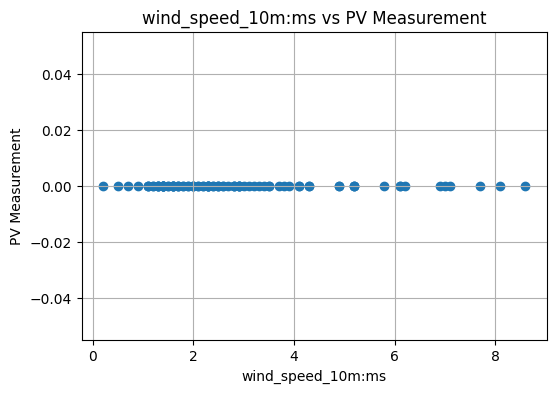

Correlation is 0.0


In [75]:
# Spesify hour (example: 12) and/or month (example: 6). Either of them can be None.
# Choose your feature. If you spesify 'feature' to be None, then it will plot for ALL feautures.

hour = 4
month = 11
feature = 'wind_speed_10m:ms'

corr = plotter.plot_feature_analysis(observed=observed, plot=True, feature=feature, hour=hour, month=month)
if corr is not None:
    print("Correlation is", corr)

In [69]:
class Observation:
    def __init__(self, feature, hour, month, corr) -> None:
        self.feature = feature
        self.hour = hour
        self.month = month
        self.corr = corr

In [70]:
# ITERATE THROUGH ALL COMBINATIONS OF MONTHS AND HOURS FOR A CHOSEN LOCATION AND SORT ON CORRELATION
# CREATES .CSV FILE
# NOTE Takes a long time to run

dataset = 'A'
observed = True

########################################################################################################################

if observed: all_features = plotter.get_all_features_observed()
else: plotter.get_all_features_estimated()

hours = list(range(24))
months = list(range(1, 13))

observations = []
for feature in all_features:
    for hour in hours:
        for month in months:
            corr = plotter.plot_feature_against_y(feature=feature, observed=observed, plot=False, hour=hour, month=month)
            obsvervation = Observation(feature, hour, month, corr)
            observations.append(obsvervation)

sorted_observations = sorted(observations, key=lambda x: -abs(x.corr))

if observed: csv_filename = "sorted_feature_correlations_" + dataset + "_observed.csv"
else: csv_filename = "sorted_feature_correlations_" + dataset + "_estimated.csv"

with open(csv_filename, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Feature', 'Hour', 'Month', 'Correlation'])

    for obs in sorted_observations:
        row_data = [obs.feature, obs.hour, obs.month, obs.corr]
        csv_writer.writerow(row_data)

print(f"CSV file '{csv_filename}' has been created.")


/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of 

CSV file 'sorted_feature_correlations_A.csv' has been created.


In [83]:
# Outputs top features with the highest correlations

df_A = pd.read_csv('sorted_feature_correlations_A_observed.csv')
df_A.head(100)

,Feature,Hour,Month,Correlation
0,clear_sky_rad:W,18,4,0.893489
1,clear_sky_energy_1h:J,18,4,0.880960
2,diffuse_rad:W,4,4,0.870915
3,diffuse_rad_1h:J,4,4,0.870835
4,diffuse_rad:W,18,4,0.866947
...,...,...,...,...
95,sun_azimuth:d,16,4,0.766325
96,diffuse_rad:W,18,8,0.765393
97,direct_rad_1h:J,7,6,0.765218
98,is_in_shadow:idx,18,4,-0.765173
